# Calibration of the Chaboche model with gaussian nonlinear calibration (ThreeDVAR)

The goal of this example is to calibrate the simulator associated with the Chaboche model with gaussian non linear calibration. 

In [1]:
import openturns as ot
import numpy as np

## Read the observations

We begin by reading the observations from the data file. There are 100 observations of the couple (strain,stress).

In [2]:
observedSample = ot.Sample_ImportFromCSVFile("calibration_chaboche_observations.csv")
nbobs = observedSample.getSize()
strainobs = observedSample[:,0]
stressobs = observedSample[:,1]
nbobs

100

In [3]:
strainobs.setDescription(["Strain"])

## Define the model

We define the model which has 4 inputs and one output `stress`.

In [4]:
def modelChaboche(X):
    strain,R,C,gamma = X
    # Workaround for https://github.com/openturns/openturns/issues/1092
    R = R*1.e6
    C = C*1.e6
    stress = R + C*(1-np.exp(-gamma*strain))
    return [stress]

In [5]:
modelFunc = ot.PythonFunction(4, 1, modelChaboche)
modelFunc.setDescription(["strain", "R", "C", "gamma", "stress"])

Define the value of the reference values of the $\theta$ parameter. In the bayesian framework, this is called the mean of the *prior* gaussian distribution. In the data assimilation framework, this is called the *background*.

In [6]:
R = 700 # Exact : 750e6
C = 2500 # Exact : 2750e6
Gamma = 8. # Exact : 10
thetaPrior = ot.Point([R,C,Gamma])
thetaPrior.setDescription(("R","C","Gamma"))

The following statement create the calibrated function from the model. The calibrated parameters Ks, Zv, Zm are at indices 1, 2, 3 in the inputs arguments of the model.

In [7]:
calibratedIndices = [1,2,3]
mycf = ot.ParametricFunction(modelFunc, calibratedIndices, thetaPrior)

The standard deviation of the observations.

In [8]:
sigmaStress = 1.e7 # (Pa)

Define the covariance matrix of the output Y of the model.

In [9]:
errorCovariance = ot.CovarianceMatrix(1)
errorCovariance[0,0] = sigmaStress**2

Defined the covariance matrix of the parameters $\theta$ to calibrate.

In [10]:
sigmaR = 0.1 * R
sigmaC = 0.1 * C
sigmaGamma = 0.1 * Gamma

In [11]:
sigma = ot.CovarianceMatrix(3)
sigma[0,0] = sigmaR**2
sigma[1,1] = sigmaC**2
sigma[2,2] = sigmaGamma**2
sigma

class=CovarianceMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[4900,0,0,0,62500,0,0,0,0.64]

In [12]:
import CalibrationGraphics as cg

## Calibration

The `ThreeDVAR` class performs the gaussian nonlinear calibration.

In [13]:
algo = ot.ThreeDVAR(mycf, strainobs, stressobs, thetaPrior, sigma, errorCovariance)

The `run` method computes the solution of the problem.

In [14]:
algo.run()

In [15]:
calibrationResult = algo.getResult()

## Analysis of the results

The `getParameterMAP` method returns the maximum of the posterior distribution of $\theta$.

In [16]:
thetaMAP = calibrationResult.getParameterMAP()
thetaMAP

class=Point name=Unnamed dimension=3 values=[747.707,2838.42,9.56768]

We can compute a 95% confidence interval of the parameter $\theta^\star$. 

In [17]:
thetaPosterior = calibrationResult.getParameterPosterior()
thetaPosterior.computeBilateralConfidenceIntervalWithMarginalProbability(0.95)[0]

class=Interval name=Unnamed dimension=3 lower bound=class=Point name=Unnamed dimension=3 values=[714.046,2352.87,7.66488] upper bound=class=Point name=Unnamed dimension=3 values=[779.187,3313.55,12.4997] finite lower bound=[1,1,1] finite upper bound=[1,1,1]

We can see that all three parameters are estimated with a large confidence interval.

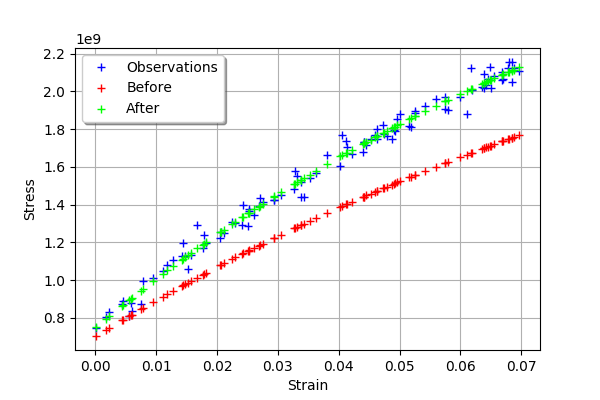

In [18]:
graph = cg.drawModelVsObservationsBeforeAndAFter(thetaPrior,thetaMAP,strainobs, stressobs,mycf)
graph.setLegendPosition("topleft")
graph

We see that there is a good fit after calibration, since the predictions after calibration (i.e. the green crosses) are close to the observations (i.e. the blue crosses).

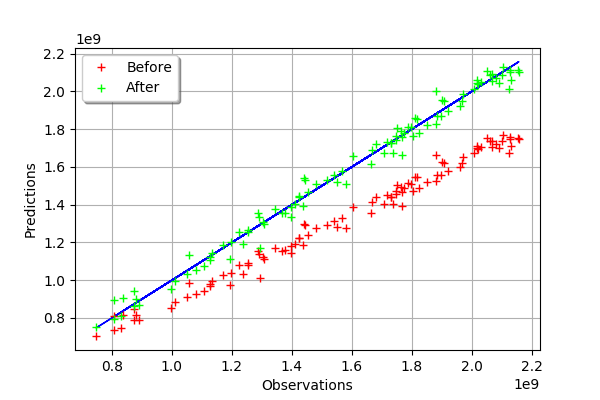

In [19]:
cg.drawObservationsVsPredictionsBeforeAfter(thetaPrior,thetaMAP,strainobs, stressobs,mycf)

We see that there is a much better fit after calibration, since the predictions are close to the diagonal of the graphics.

The observation error is predicted by bootstraping the problem at the posterior. 

In [22]:
observationError = calibrationResult.getObservationsError()
observationError

class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] sigma=class=Point name=Unnamed dimension=1 values=[1e+07] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1]

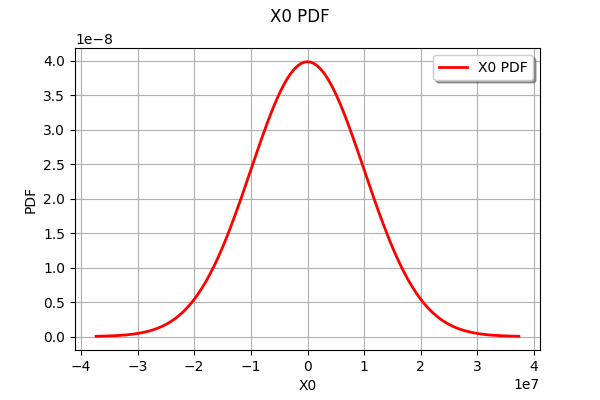

In [23]:
observationError.drawPDF()

This can be compared to the residuals distribution, which is computed at the posterior.

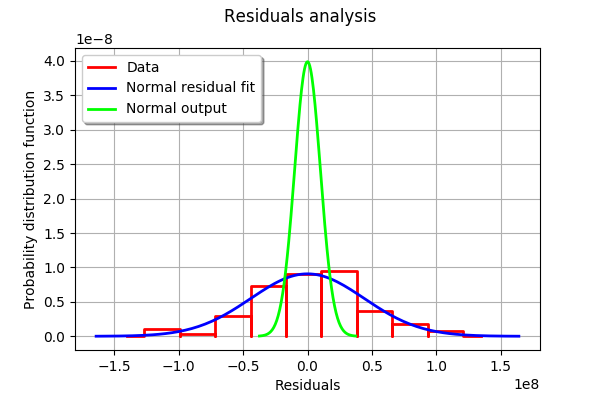

In [24]:
graph = cg.drawResiduals(thetaMAP,strainobs, stressobs,mycf, errorCovariance)
graph.setLegendPosition("topleft")
graph

The analysis of the distribution of the residuals (the red histogram) shows that the distribution is centered on zero and symmetric. This indicates that the calibration performed well. 

Moreover, the distribution of the residuals is close to being gaussian, since the red histogram is close to the blue gaussian fit. This indicates that the observation error might well be gaussian.

The covariance error distribution (in green) is much narrower than the actual residuals distribution. This shows that the observations error was underestimated in the prior observation error distribution.

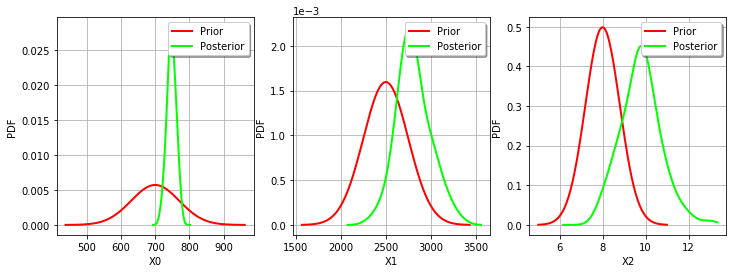

In [25]:
_ = cg.drawThetaDistribution(calibrationResult)

We see that the prior and posterior distribution are close to each other, but not superimposed: the observations significantly brought information during the calibration.